# Reinforcement learning homework
---

Jordi Morera

### Homework 1: Simple parametric policies

Let $\phi : X x A \rightarrow \mathbb{R}^{d}$

Compute $\nabla_{\theta}log(\pi_{\theta}(a|x))$ for the Boltzmann policy:

$$
\pi_{\theta}(a | x)=\frac{e^{\theta^{\top} \phi(x, a)}}{\sum_{b} e^{\theta^{\top} \phi(x, b)}}
$$

*Answer:*

$$
\begin{array}{c}{\nabla_{\theta} \log \pi_{\theta}(a | x)=\nabla_{\theta} \log \frac{e^{\theta^{\top} \phi(x, a)}}{\sum_{b} e^{\theta^{\top} \phi(x, b)}}=\\\nabla_{\theta} \log e^{\theta^{\top} \phi(x, a)}-\nabla_{\theta} \log \sum_{b} e^{\theta^{\top} \phi(x, b)}=}\end{array}
$$

Computing the gradient

$$
\begin{array}{c}{{\phi(x, a)-\frac{1}{\sum_{b} e^{\theta^{\top} \phi(x, b)}}\sum_{b'} e^{\theta^{\top} \phi(x, b')}}=\\{\phi(x, a)-\sum_{b'} \frac{\exp \left(\theta^{\top} \phi(x, b')\right)}{\sum_{b} \exp \left(\theta^{\top} \phi\left(x, b)\right)\right)} \phi(x, b')}}\end{array}
$$

Finally obtaining 
$$
\begin{array}{c}{\nabla_{\theta}log(\pi_{\theta}(a|x)) = \phi(x, a)-\sum_{b} \pi_{\theta}(b|x) \phi(x, b)}\end{array}
$$

Which can be rewritten as

$$
\nabla_{\theta} \log \pi_{\theta}(a| x)=\phi(x, a)-\mathbb{E}_{\pi_{\theta}}[\phi(x, \cdot)]
$$

### Homework 2: Policy gradient in a simple MDP

Run a policy gradient algorithm with a Boltzmann policy using $\phi_i(x,a) = 𝟏_{(a=1)}$

First we set up the environment the agent interacts with as ```Environment```

In [3]:
# Importing all libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import itertools

# Some settings for plotting
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10

# First we set up our environment and agent
"""
Environment the Agent interacts with.

Has probability of reward p for each action a

The environment only has one state and two possible actions.

"""
# Environemnt
class Environment():
    
    # Initialization with probabilities
    def __init__(self, delta):
        self.p1 = 0.5
        self.p2 = 0.5 + delta
    
    # Return reward based on probabilities and action taken
    def step(self, action):
        if action == 0:
            return np.random.binomial(1,self.p1)
        elif action == 1:
            return np.random.binomial(1,self.p2)
        else:
            raise ValueError("Action {} not correct".format(action))

Now we define the Boltzmann Policy as another class:

- Has two parameters 
- $\phi$ gives a linear combination of state (which is always the same) and action $a$
- Weights $\theta$


$$
\pi_{\theta}(a | x)=\frac{e^{\theta^{\top} \phi(x, a)}}{\sum_{b} e^{\theta^{\top} \phi(x, b)}}
$$


Where $\phi$ is just the indicator function.

So the policy will be:

$$
\pi_{\theta}(a_1 | x)  = \frac{e^{\theta_1}}{e^{\theta_1} + e^{\theta_2}}
$$

and analogously for $a_2$.

$\pi_\theta(a | x)$ then returns a probability of picking action $a$, given the state and possible actions. At each step, the policy then picks and action at random, based on the probabilites found through evaluating the policy given the current weights.

In [4]:
# Policy Class
class BoltzmannPolicy():
    def __init__(self):
        # Initialize with weights and phi as the identity
        self.phi = np.identity(2)
        self.weights = [0.5,0.5]
        
    # Evaluating both a_1 and a_2, returns vector of policies
    def evaluate(self):
        return np.exp(self.weights)/np.sum(np.exp(self.weights))
    
    # Picks action based on policy evaluation (depends on learned weights)
    # We choose an action either 0 or 1 based on the probabilities 
    # returned from the policy evaluation
    def pick_action(self):
        return np.random.choice([0,1],p = self.evaluate())
    
    # The gradient of the function as defined in question 1
    # Gradient depends on the choosen action
    def eval_gradient(self,action):
        return self.phi[:,action] - self.phi @ self.evaluate()

Having set up the environment and the policy function we can define a learning algorithm for finding the optimal policy given the environment and policy function.

We use a temporal difference actor critic algorithm with a linear function approximation to learn the optimal weights.

Attributes of the ```policy_gradient```:
- ```environment```: We just defined this with a given delta
- ```gamma```: Discount factor, "how much does the future matter" -> in this case it doesn't!
- ```policy```: In this case Boltzmann as defined previously
- ```seed```: Random seed, for reproducability
- ```step_type```: Learning rate, we will compare these later (like learning rate in SGD)
- ```delta```: The environment parameter (how much is action 2 better than 1)
- ```V_w```: Weights of the value function approximatoin
- ```beta```: Learning rate for the value function


We train the algorithm with: ```policy_gradient.train()```
- Attribute: Number of steps

At each training step we sample an action and the according reward and update our policy based on policy gradient.

### Question 2.1
$\gamma$ does not play a role in this policy gradient! 

In [25]:
# reinforce algorithm     
class policy_gradient():
    "Temporal difference actor-critic algorithm with linear function aproximation"
    # Init parameters
    def __init__(self, delta, c, beta = 0.05, step_type = "fixed", seed = 1 ):
        self.env = Environment(delta)
        self.policy = BoltzmannPolicy()
        self.seed = seed
        self.step_type = step_type
        self.delta = delta
        self.c = c
        
        # Changing step types 
        if  step_type == 'fixed':
            self.alpha = lambda k : c
        elif step_type == 'lin_dec':
            self.alpha = lambda k : c/k
        elif step_type == 'quad_dec':
            self.alpha = lambda k : c/(k**2)
        elif step_type == 'sqrt_dec':
            self.alpha = lambda k : c/np.sqrt(k)
        else:
            raise ValueError("Step size type {} not correct".format(step_type))
        
        np.random.seed(seed)
    
    def train(self, train_steps):
            
        # We initialize some logging info
        train_logs = []
        itr_logs = { 
            "train_step" : 0,
            "delta" : self.delta,
            "alpha" : self.alpha(1),
            "step_type" : self.step_type,
            "seed" : self.seed,
            "policy" : 0,
            "w1" : self.policy.weights[0],
            "w2" : self.policy.weights[1],
            "action" : 0,
            "reward" : 0,
            "cum_reward" : 0,
            "c" : self.c
        }
            
        rewards = []
        policy_evals = []
        
        # We simulate the action reward and update our policy based on the gradient 
        for i in range(train_steps): 


            # Sample one action and the resulting reward
            action = self.policy.pick_action()
            rewards.append(self.env.step(action))
            
            # Now we evalutate the policy based on the taken action
            policy_evals.append(self.policy.eval_gradient(action))
            
            # We estimate the policy gradient based on the average rewards and policy gradients
            gk = np.dot(rewards,policy_evals)/len(rewards)
            
            # We update the policy weights using the estimated policy gradient in a gradient ascent manner
            self.policy.weights +=  self.alpha(i+1) * gk
        
            # Store training logs
            aux = { 
                "train_step" : i+1,
                "alpha" : self.alpha(i+1),
                "policy" : self.policy.evaluate()[1],
                "w1" : self.policy.weights[0],
                "w2" : self.policy.weights[1],
                "action" : action,
                "reward" : rewards[-1],
                "cum_reward" : np.sum(rewards),
                
            }
            itr_logs.update(aux)
            train_logs.append(copy.deepcopy(itr_logs))
            
        # Return results
        return  pd.DataFrame(train_logs)

### Simulations 

We run the simulations for checking convergence of the algorithm.

In [27]:
# Parameters for simulations
train_steps = 5000
seeds = [2,3,5] # Some seeds for getting different random states
delta = 0.1
c = 0.1

# Setting up result dataframes
train_plot = pd.DataFrame()
ep_plot = pd.DataFrame()

# For each seed, simulate and store in data frame
for seed in seeds:
    reinf_alg = policy_gradient(delta = delta, 
                          c = c,
                          step_type = "fixed",
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot = train_plot.append(train_data, ignore_index= True)

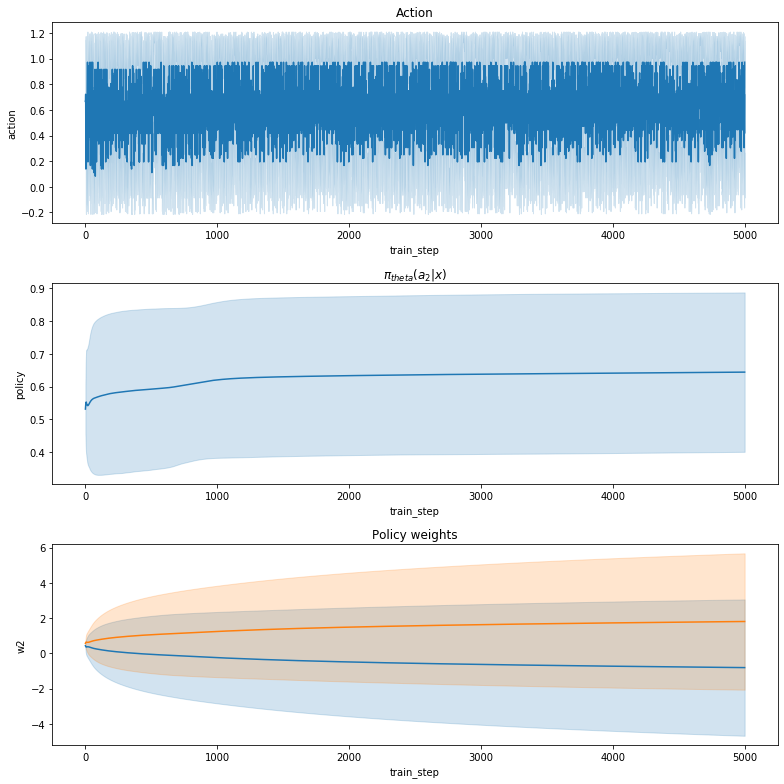

In [78]:
fig,axes = plt.subplots(3,1,figsize=(11, 11))
sns.lineplot(x = 'train_step', y = 'action', ci = 'sd', data = train_plot, ax = axes[0]).set_title("Action")
sns.lineplot(x = 'train_step', y = 'policy', ci = 'sd', data = train_plot, ax = axes[1]).set_title("$\pi_{theta}(a_{2}|x)$")
sns.lineplot(x = 'train_step', y = 'w1', ci = 'sd', data = train_plot, ax = axes[2]).set_title("Policy weights")
sns.lineplot(x = 'train_step', y = 'w2', ci = 'sd', data = train_plot, ax = axes[2]).set_title("Policy weights")
plt.tight_layout()

plt.savefig("img/policy_gradient_convergence")

First plot shows the mean actions taken over tranining steps and seed and the corresponding standard deviation. The second plot shows the convergence of the policy function and the third shows the evolution of the weighs $\theta$.

*Note that the policy values are plotted together with the sd over different seeds. Policy function values cannot be higher than 1 or lower than 0, however, mean +- sd can be higher than 1. The main objective is to illustrate the volatility of the measure.*

#### 2.1  How does the choice of $\gamma$ influence the behavior of the algorithm?

*Answer:* It doesn't! Why? Because we just have one state and because we said so. (h(x) is what matters!).


For other environments:
The gamma parameter controls the discounting factor of the future discounted reward. The higher is gamma, the more rewards from future episodes we consider to take an action. This leads to more volatile policy function. 

(Think of two agents with different time horizons in a game where you could end early or late, with varying payoffs).

#### 2.2 Fix 𝛾 = 0.99 and Δ = 0.05, and consider the step sizes $\frac{\alpha_{k}}{\sqrt{k}} ,\frac{\alpha_{k}}{k}, \text { and },\frac{\alpha_{k}}{k^{2}}$ for various choices of 𝑐. Plot $\pi_{\theta_{k}}(a_{2}|x)$ as a function of 𝑘.

*Answer:*

In [ ]:
# Types of steps to evaluate
step_types = ['fixed' , 'lin_dec' , 'quad_dec' ,'sqrt_dec']

# Parameters
delta = 0.05
seeds = [2,3,4]
cs = [0.01,0.2,1]


# Setting up the result df
train_plot = pd.DataFrame()

# For each combination of seed, step_type and c, run the algorithm, store results
for seed,step_type,c in itertools.product(seeds,step_types,cs):
    print(seed,step_type,c)
    reinf_alg = policy_gradient(delta = delta, 
                          c = c,
                          step_type = step_type,
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot = train_plot.append(train_data, ignore_index= True)

2 fixed 0.01
2 fixed 0.2
2 fixed 1
2 lin_dec 0.01
2 lin_dec 0.2


We plot the results:

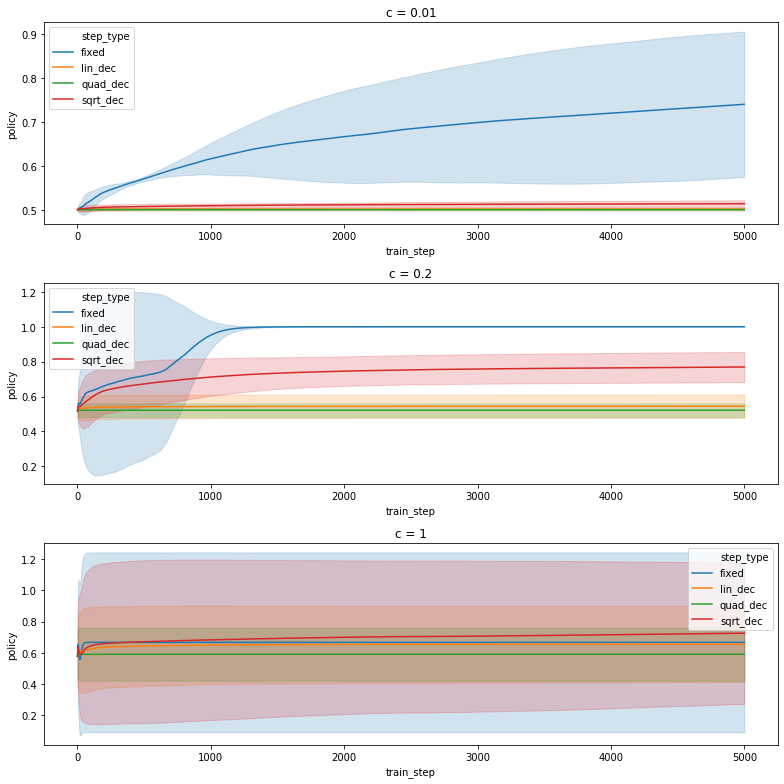

In [49]:
fig,axes = plt.subplots(3,1, figsize = (11,11))

for i,c in enumerate(cs):
    sns.lineplot(x='train_step', y = 'policy', ci = 'sd', hue = "step_type", 
                 data= train_plot[train_plot.c == c],ax = axes[i]).set_title(f"c = {c}")

plt.tight_layout()
plt.savefig("img/policy_gradient_convergence_cs")

We find that, for delta small, only fixed step size manages to get the right answer 100% of the times. The other step sizes, for a given initial c, some seeds converge to the wrong policy. The issue here is that the learning rate decreases faster than we can update our parameters, so we get stuck in the beginning. On the other hand, for larger learning rates, the policy jumps in the beginning and then gets stuck as well. 

The optimal learning rate also depends on the parameters you're estimating, since we're starting with small $\theta$, large learning rates send the parameters around by too much.

#### 2.3. Pick the best of these step sizes and plot $\pi_{\theta_{k}}(a_{2}|x)$ as a function of 𝑘 for Δ ∈ {0.01,0.05,0.1,0.5}.

*Answer:*

Again we run a couple of simulations:

In [10]:
# Setting params
step_type = 'fixed'
deltas = [0.01,0.05,0.1,0.5]
train_steps = 1000
c =0.2
seeds = [2,3,4]


train_plot = pd.DataFrame()

for seed,delta in itertools.product(seeds,deltas):
    reinf_alg = policy_gradient(delta = delta, 
                          c = c,
                          step_type = step_type,
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot = train_plot.append(train_data, ignore_index= True)

Plot the results:

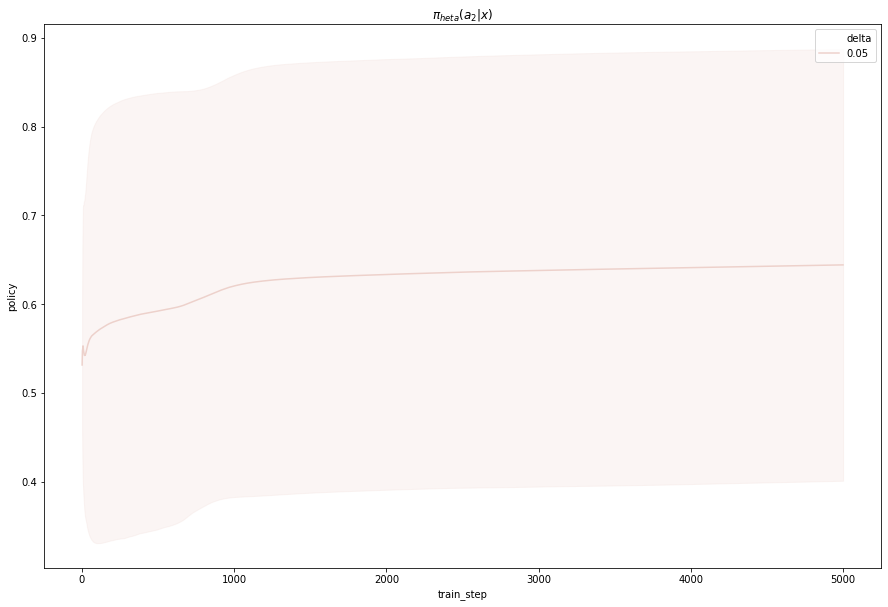

In [87]:
sns.lineplot(x = 'train_step', 
             y = 'policy', 
             ci = 'sd', 
             hue = 'delta', 
             data = train_plot, legend = 'full').set_title("$\pi_{\theta}(a_{2}|x)$")
plt.savefig("img/policy_gradient_convergence_deltas")

We observe faster convergence for big deltas. This makes sense intuitively, since the "signal" from choosing the correct action is stronger on average. For lower deltas we see that we sometimes don't even converge to the optimum.

### Homework 3 : Basic bandit algorithms

Consider the bandit problem from Homework 2.

#### 3.1. Implement UCB and plot its total reward after 𝑇 = 10000 rounds as a function of Δ.

*Answer:*

First we set up UCB class, which takes the environment and the delta into account.

In [61]:
class UCB():
    def __init__(self, delta, beta):
        self.env = Environment(delta)
        self.beta = beta
        self.means = np.zeros(2)
        self.counter =np.zeros(2)
        self.delta = delta
        
        
        #Force one trial to avoid 0 division
        for action in range(2):
            reward = self.env.step(action)
            self.update_mean(action,reward)
     
    # Choose the arm based on the updated mean and the other params
    def choose_arm(self):
        return np.argmax(self.means + np.sqrt(self.beta*np.log(np.sum(self.counter))/self.counter))
    
    # We update the "running mean"
    def update_mean(self,action,reward):
        
        self.counter[action] += 1
        self.means[action] = self.means[action] +  1/(1+self.counter[action])*(reward-self.means[action])
     
    # Training: Choose an arm, get reward (or not), update mean, choose arm, get reward..... robot is tired
    def train(self, iterations):
        
        
        train_logs = pd.DataFrame()
        tot_rew = 0
        
        for i in range(iterations):
            
            action = self.choose_arm()
            reward = self.env.step(action)
            self.update_mean(action,reward)
            
            tot_rew += reward
            
        return tot_rew
        

We simulate again:

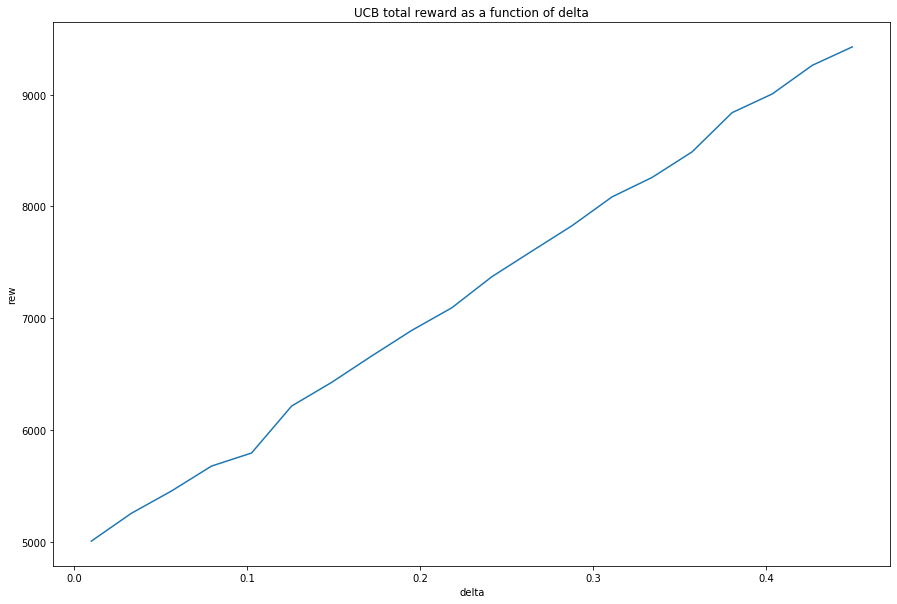

In [86]:
beta = 2
deltas = np.linspace(0.01,0.45,20)
seeds  =[2]

rews_UCB = []
for seed,delta in itertools.product(seeds,deltas):
    reinf_alg = UCB(delta,beta)
    rew = reinf_alg.train(10000)        
    _ = { 'seed':seed, 'delta': delta, 'rew':rew}
    rews_UCB.append(copy.deepcopy(_))
        
    
res_UCB = pd.DataFrame(rews_UCB)  
sns.lineplot(x = 'delta', y = 'rew', ci = 'sd', data = res_UCB, legend = 'full').set_title("UCB total reward as a function of delta")
plt.savefig("img/UCB_reward")

So for very small delta, we have small total rewards.

#### 3.3. Implement 𝜀-greedy with 𝜀 = 𝑐/𝑡 for various choices of c. Plot its total reward after 𝑇 = 10000 rounds as a function of Δ.

*Answer:*

In [52]:
class eps_greedy():
    def __init__(self, delta, c, seed =1):
        self.env = Environment(delta)
        self.eps = lambda t: c/t
        self.means = np.zeros(2)
        self.counter =np.zeros(2)
        self.delta = delta
        
        np.random.seed(seed)
                
        #Force one trial to avoid 0 division
        for action in range(2):
            reward = self.env.step(action)
            self.update_mean(action,reward)
    
    # In epsilon greedy we choose the arm either randomly or based on the maximum expected reward
    def choose_arm(self, it):
        
        # Draw a random number, check if bigger smaller eps, if so, draw random action
        if np.random.uniform() < self.eps(it):
            return np.random.randint(2)
        
        # Else choose arm with maximum estimated reward based on previous trials
        else:
            return np.argmax(self.means)
    
    # update the mean 
    def update_mean(self,action,reward):
        
        self.counter[action] += 1
        self.means[action] = self.means[action] +  1/(1+self.counter[action])*(reward-self.means[action])
      
    # Training: Draw action, get reward, update params, repeat!
    def train(self, iterations):
        
        
        train_logs = pd.DataFrame()
        tot_rew = 0
        
        for i in range(iterations):
            
            action = self.choose_arm(i+1)
            reward = self.env.step(action)
            self.update_mean(action,reward)
            
            tot_rew += reward
                        
        return tot_rew

Simulating the $\epsilon$-greedy policy:

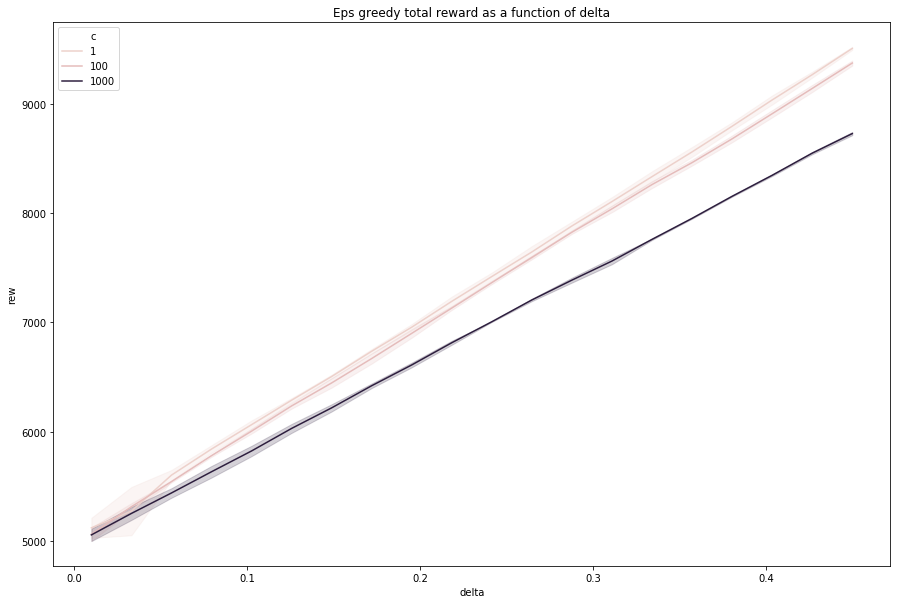

In [84]:
# Parameter initialization
seeds = [2,3,4]
cs = [1,100,1000]
deltas = np.linspace(0.01,0.45,20)

rews_eps = []

# Simulate
for seed,c,delta in itertools.product(seeds,cs,deltas):
    reinf_alg = eps_greedy(delta,c, seed)
    rew = reinf_alg.train(10000)        
    _ = { 'seed':seed,'c':c, 'delta': delta, 'rew':rew}
    rews_eps.append(copy.deepcopy(_))

    
res_eps = pd.DataFrame(rews_eps)  
sns.lineplot(x = 'delta', y = 'rew', ci = 'sd',hue ='c', data = res_eps, legend = 'full').set_title("Eps greedy total reward as a function of delta")
plt.savefig("img/Eps_greedy_reward")

For smaller $c$ we are behaving less random quicker, compared to larger $c$. Thus for smaller $\Delta$ the the chance of getting stuck in the wrong arm get's bigger, while we converge much quicker to the correct arm if $\Delta$ is large. With large $\Delta$ we get better signals and the updates contain more information, so it doesn't hurt us to converge fast.

#### 3.3. Contrast the newly obtained results with those obtained for policy gradient methods. Which algorithm do you think is the best and why.

*Answer:*

In [56]:
seeds = [3]
train_steps = 10000
c =0.2
deltas = np.linspace(0.01,0.45,10)


train_plot_AC = pd.DataFrame()

for seed,delta in itertools.product(seeds,deltas):
    reinf_alg = policy_gradient(delta = delta, 
                          c = c,
                          step_type = step_type,
                          seed = seed)
    train_data = reinf_alg.train(train_steps)
    train_plot_AC = train_plot_AC.append(train_data, ignore_index= True)


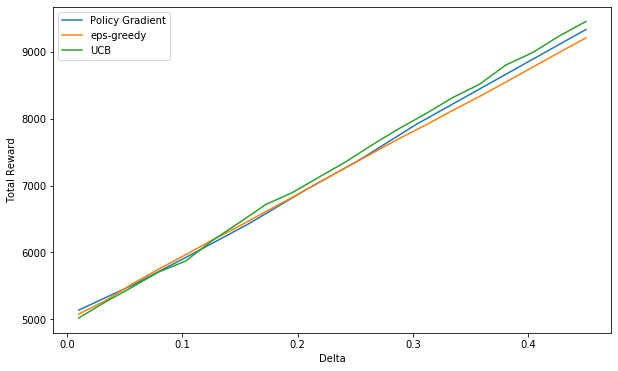

In [83]:
AC_plot = train_plot_AC[["cum_reward","delta"]].groupby('delta').max()
eps_plot = res_eps[["rew","delta"]].groupby('delta').mean()
ucb_plot = res_UCB[["rew","delta"]].groupby('delta').mean()

plt.figure(figsize=(10,6))
plt.plot(AC_plot.index,AC_plot["cum_reward"], label = "Policy Gradient")
plt.plot(eps_plot.index,eps_plot["rew"], label = "eps-greedy")
plt.plot(ucb_plot.index,ucb_plot["rew"], label = "UCB")


plt.legend()
plt.xlabel("Delta")
plt.ylabel("Total Reward")

plt.savefig("img/algroithm_comparison")

We see that there is not such a big difference between the different algorithm. Since Policy-Gradients are kind of tricky to optimize, UCB and even eps-greedy seem to be sensible alternatives.